In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import os
import datetime as dt
import re

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from yellowbrick.regressor import ResidualsPlot

In [2]:
# import wiki_nlp and clean
wiki_nlp = pd.read_csv('../NLP/wiki_nlp.csv')
wiki_nlp = wiki_nlp.rename(columns={'this_article_unique_name': 'article_name'})
wiki_nlp.set_index('article_name', inplace=True) #set article name as index
wiki_nlp.fillna(value = 0, inplace=True)
wiki_nlp = wiki_nlp.reset_index()
wiki_nlp.drop(columns=['level_0','Unnamed: 0'], inplace=True, errors='ignore')

In [3]:
# import target (num of lang) from ExtractClean
wiki_feat = pd.read_csv('../ExtractClean/wiki_10feat.csv')
wiki_lang = wiki_feat[['article_name','languages']]
wiki_lang = wiki_lang.rename(columns={'languages': 'lang_total_num_target'})

# join two dataframes
wiki_nlp_comb = wiki_lang.merge(wiki_nlp, left_on='article_name', right_on='article_name')

In [4]:
wiki_nlp_comb = wiki_nlp_comb.reset_index()
wiki_nlp_comb.set_index('article_name', inplace=True) #set article name as index
wiki_nlp_comb.drop(['1858', 'Ice','Dysprosium','Eucalyptus','.uy','2000s in music'], inplace=True, errors='ignore') #outliers 

In [5]:
# remove columns that have less than 300 entries all rows combined
column_totals = wiki_nlp_comb.sum(axis = 0).sort_values(ascending=False)
print(len(column_totals))
print(column_totals.where(column_totals > 300).count())
frequent_words = column_totals.where(column_totals > 300)
frequent_words = frequent_words.dropna() # list of columns with counts > 300

31302
483


In [6]:
frequent_words_list = list(frequent_words.index)
df_columns = wiki_nlp_comb.columns
columns_to_be_dropped = []
for column in df_columns:
    if column not in frequent_words_list:
        columns_to_be_dropped.append(column)

In [7]:
wiki_nlp_comb.drop(columns = columns_to_be_dropped, inplace=True, errors='ignore')

In [8]:
#normalize all features except languages

# normalized_wiki_nlp = (wiki_nlp_comb - wiki_nlp_comb.min()) / (wiki_nlp_comb.max()-wiki_nlp_comb.min())
normalized_wiki_nlp = (wiki_nlp_comb - wiki_nlp_comb.mean()) / wiki_nlp_comb.std()
normalized_wiki_nlp['lang_total_num_target'] = wiki_nlp_comb['lang_total_num_target']

In [9]:
normalized_wiki_nlp.drop(columns=['level_0'], inplace=True, errors='ignore')
normalized_wiki_nlp.sort_values(by='lang_total_num_target',ascending=False).head(10)

,lang_total_num_target,february,june,war,party,retrieved,december,italy,isbn,county,...,dam,shrew,castle,paok,over,evangelical,tornado,mpc,jpl,socorro
article_name,,,,,,,,,,,,,,,,,,,,,
Lubusz Voivodeship,75,-0.097208,-0.174928,-0.102447,-0.096207,-0.071926,-0.100553,-0.048353,-0.103288,7.995493,...,-0.021214,-0.023612,-0.036432,-0.016846,-0.019073,-0.023508,-0.01976,-0.016591,-0.016591,-0.016591
Jeans,73,0.745986,0.701039,-0.102447,-0.096207,1.717854,-0.100553,2.189447,0.561258,-0.164430,...,-0.021214,-0.023612,-0.036432,-0.016846,-0.019073,-0.023508,-0.01976,-0.016591,-0.016591,-0.016591
Gamete,69,-0.097208,-0.174928,-0.102447,-0.096207,-0.000335,-0.100553,-0.048353,-0.103288,-0.164430,...,-0.021214,-0.023612,-0.036432,-0.016846,-0.019073,-0.023508,-0.01976,-0.016591,-0.016591,-0.016591
Temple in Jerusalem,66,-0.097208,0.701039,0.752667,-0.096207,0.500804,-0.100553,-0.048353,1.447319,-0.164430,...,-0.021214,-0.023612,-0.036432,-0.016846,-0.019073,-0.023508,-0.01976,-0.016591,-0.016591,-0.016591
Rosalyn Sussman Yalow,65,-0.097208,0.701039,0.752667,-0.096207,0.500804,-0.100553,-0.048353,0.782773,-0.164430,...,-0.021214,-0.023612,-0.036432,-0.016846,-0.019073,-0.023508,-0.01976,-0.016591,-0.016591,-0.016591
Republic of Genoa,64,-0.097208,0.701039,2.890452,-0.096207,0.142847,-0.100553,7.038013,1.890350,4.595525,...,-0.021214,-0.023612,-0.036432,-0.016846,-0.019073,-0.023508,-0.01976,-0.016591,-0.016591,-0.016591
Pope Nicholas II,63,-0.097208,-0.174928,0.966446,-0.096207,-0.286700,-0.100553,-0.048353,-0.103288,-0.164430,...,-0.021214,-0.023612,-0.036432,-0.016846,-0.019073,-0.023508,-0.01976,-0.016591,-0.016591,-0.016591
Gerard Butler,61,2.713440,0.920030,-0.102447,-0.096207,2.720132,0.324390,-0.048353,-0.103288,-0.164430,...,-0.021214,-0.023612,-0.036432,-0.016846,-0.019073,-0.023508,-0.01976,-0.016591,-0.016591,-0.016591
Flame,60,-0.097208,-0.174928,-0.102447,-0.096207,-0.000335,-0.100553,-0.048353,0.782773,-0.164430,...,-0.021214,-0.023612,-0.036432,-0.016846,-0.019073,-0.023508,-0.01976,-0.016591,-0.016591,-0.016591


In [10]:
normalized_wiki_nlp.shape

(3633, 482)

In [11]:
normalized_wiki_nlp.dropna(axis='columns',inplace=True)
normalized_wiki_nlp.shape

(3633, 482)

In [12]:
# Create an empty model
lr_full = LinearRegression()

# Features
X = normalized_wiki_nlp.loc[:, 'february':'socorro']

# Target
y = normalized_wiki_nlp['lang_total_num_target']

# Fit  
lr_full.fit(X, y)

# Score
lr_full.score(X, y)

0.47570830938239184

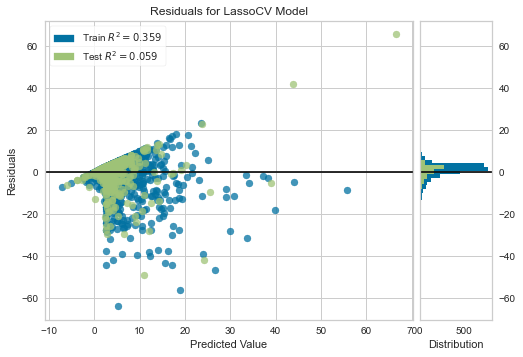

0.14682982095801195

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
model = LassoCV()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure
visualizer.alpha_

In [15]:
len(visualizer.coef_)

481

In [30]:
coefs_list = list(zip(X.columns, visualizer.coef_))
coefs_df = pd.DataFrame(coefs_list, columns =['column_name', 'coef']) 
coefs_df.sort_values(by='coef',ascending=False)

,column_name,coef
332,population,1.212857
8,county,0.814047
211,roman,0.779921
26,also,0.703669
83,le,0.666219
...,...,...
55,united,-0.249402
349,well,-0.271809
425,show,-0.279516
291,date,-0.377511


In [ ]:
counter = 0
for num in coefs_df['coef']:
    if num != 0:
        counter += 1
counter

In [ ]:
# model = LassoCV()
# model.fit(X_train, y_train)
# model.alpha_

In [70]:
model.fit(X_train, y_train)
prediction = model.predict(X_test)
residual = prediction - y_test

residual.sort_values(ascending=False).head(20)

article_name
Immigration to the United States                             65.505048
Suite from Henry V                                           16.356390
Presidency of Jomo Kenyatta                                  12.010648
Home to Roost                                                11.801096
History of Shepherd's Bush                                   11.690388
Opinion polling for the 2020 Israeli legislative election    10.548506
List of AAU men's basketball champions                        9.989989
Food marketing toward children                                9.664831
Albert Laponneraye                                            8.949458
2nd Arkansas Cavalry Regiment (Slemons')                      8.016740
Homosexuality in English football                             7.898647
William Hawte                                                 7.833084
All-Asian Women's Conference                                  7.629663
Supporters of S.L. Benfica                                    7.

In [20]:
diff_list = []
for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    model = Lasso(alpha = 1.5)

    model.fit(X_train, y_train)  
    train_score = model.score(X_train, y_train)  
    test_score = model.score(X_test, y_test)
    diff = train_score - test_score
    diff_list.append(diff)
print(diff_list)

[0.030590165053654528, 0.04125434028602937, 0.017519508809132445, 0.03767430186772969, 0.03909830250650592, 0.035626223373834254, 0.0548665084592902, 0.04699246822810943, 0.04771168279817817, 0.056542161389751655, 0.07746648469796968, 0.045055423496880964, 0.03633690903019082, 0.07145479242156427, 0.06333208051886763, 0.04602626812186161, 0.054851884967323516, 0.05204524888498552, 0.06321955869789864, 0.05097598723778718, 0.05999589569974917, 0.011956937115491506, 0.009830477585001107, 0.04463044289894569, 0.02254878330512511, 0.07377245988130432, 0.05530600494395177, 0.05097112459099795, 0.06529668251104404, 0.08539185651396286]


In [21]:
print(sum(diff_list)/30)

0.048278032196437295


In [76]:
normalized_wiki_nlp.to_csv(r'wiki_nlp_small.csv')